<center><h1><font color='teal'>GENDER PREDICTION</font></h1><center> 

## Introduction

Data type - organic process data. Formed organically as a result of the collection of Sberbank transactions.
The data is considered I.I.D. The observation is independent of all other datasets and all values we consider are the result of some general statistical distribution.

We need to predict the gender of a customer based on their transactional data. 
**The metric is the ROC AUC.**

In [1]:
# import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as st
import re
import plotly.graph_objects as go

In [2]:
# read a dataset
train = pd.read_csv('train_set.csv', delimiter = ";")
codes = pd.read_csv('codes.csv', delimiter = ";")
types = pd.read_csv('types.csv', delimiter = ";")
transactions = pd.read_csv('transactions.csv', delimiter = ";")
test = pd.read_csv('test_set.csv', delimiter = ";")

## Explore the dataset

In [3]:
train

client_id  target
0      75063019       0
1      86227647       1
2       6506523       0
3      50615998       0
4      95213230       0
...         ...     ...
5995   71577803       0
5996    8128547       1
5997   26055781       0
5998   73504380       1
5999    1846496       0

[6000 rows x 2 columns]

> For train we have 6000 random clients and their gender.

In [4]:
codes

code                                   code_description
0    5944  Магазины по продаже часов, ювелирных изделий и...
1    5621                           Готовые сумочные изделия
2    5697       Услуги по переделке, починке и пошиву одежды
3    7995                       Транзакции по азартным играм
4    5137             Мужская, женская и детская спец-одежда
..    ...                                                ...
179  5044  Офисное, фотографическое, фотокопировальное, и...
180  5983  Горючее топливо — уголь, нефть, разжиженный бе...
181  5994               Дилеры по продаже печатной продукции
182  5192              Книги, периодические издания и газеты
183  7922                 Театральные продюсерские агентства

[184 rows x 2 columns]

> Type code 184, which gives information about the places where the money was spent.

In [5]:
types

type                                   type_description
0    8001                 Установление расх. лимита по карте
1    2411  Перевод с карты на счет др.лица в одном тер. б...
2    4035                                    н/д(нет данных)
3    3001            Комиссия за обслуживание ссудного счета
4    2420  Перевод с карты на счет физ.лица в другом тер....
..    ...                                                ...
150  4110                 Плата за получение наличных в АТМ.
151  2320     Безналичный перевод денежных средств через POS
152  7040  Перевод на карту (с карты) через POS (в предел...
153  2433  Перевод с карты на счет физ.лица в другом банк...
154  2431  Перевод с карты на счет физ.лица в другом банк...

[155 rows x 2 columns]

> 155 types of transactions with their descriptions.

In [6]:
transactions

client_id      datetime  code  type         sum
0        96372458  421 06:33:15  6011  2010  -561478.94
1        24567813  377 17:20:40  6011  7010    67377.47
2        21717441   55 13:38:47  6011  2010   -44918.32
3        14331004  263 12:57:08  6011  2010 -3368873.66
4        85302434  151 10:34:12  4814  1030    -3368.87
...           ...           ...   ...   ...         ...
130034   15836839  147 11:50:53  5411  1010   -26344.59
130035   28369355  305 11:59:34  4829  2330   -24705.07
130036   40949707  398 21:13:58  5411  1110   -40353.72
130037    7174462  409 13:58:14  5411  1010   -25536.06
130038   92197764  319 00:00:00  5533  1110   -12127.95

[130039 rows x 5 columns]

> The main data set where all committed transactions are stored, there we have 130k transactions.

In [7]:
test

client_id
0      61240380
1      34114030
2      15926722
3      50598019
4      76475250
...         ...
2651   13491189
2652   54047312
2653   68859452
2654   95721840
2655    4022959

[2656 rows x 1 columns]

>Test dataset with 2656 row.

In [8]:
# print size of all tables
print('Size of dataset:\n')
print('train', train.shape)
print('codes', codes.shape)
print('types', types.shape)
print('test', types.shape)
print('transactions', transactions.shape)

Size of dataset:

train (6000, 2)
codes (184, 2)
types (155, 2)
test (155, 2)
transactions (130039, 5)


In [53]:
print('duplicated values',transactions.duplicated().sum())
print('-'*20)
print('null values',transactions.isnull().sum())
print('-'*20)
print('null values',codes.isnull().sum())
print('-'*20)
print('null values',types.isnull().sum())

duplicated values 29
--------------------
null values client_id       0
datetime        0
code            0
type            0
sum             0
day             0
hour            0
part_day        0
sum_type        0
sum_cat         0
ordered_day     0
time            0
time_of_day     0
day_type        0
week_num        0
day_of_week     0
month           0
day_of_month    0
dtype: int64
--------------------
null values code                0
code_description    0
dtype: int64
--------------------
null values type                0
type_description    0
dtype: int64


In [10]:
# number of unique
print('Number of unique:')
print(transactions['client_id'].nunique())

# top 10 clients who most often used the services of the bank
transactions['client_id'].value_counts()[:10]

Number of unique:
8656


70780820    2777
25270793     508
87252636     497
11701078     470
76043922     463
29041434     442
53854864     380
10004871     372
29894123     364
85861930     335
Name: client_id, dtype: int64

In [54]:
object_transactions = transactions.astype('object')
transactions_wo_date = object_transactions.drop('datetime',1)

print(object_transactions.describe())

        client_id      datetime    code    type        sum     day    hour  \
count      130039        130039  130039  130039  130039.00  130039  130039   
unique       8656        114770     175      67   27450.00     457      24   
top      70780820  456 00:00:00    6011    1010   -2245.92     448       0   
freq         2777            60   27917   30802    7487.00     434   16334   

       part_day sum_type  sum_cat  ordered_day      time time_of_day day_type  \
count    130039   130039   130039       130039    130039      130039   130039   
unique        4        2        6          457     55773           4        3   
top     daytime  outcome        3          448  00:00:00     daytime  weekday   
freq      48928   105728    25299          434     15496       48928    72039   

        week_num  day_of_week   month  day_of_month  
count     130039       130039  130039        130039  
unique        66            7      12            16  
top           62            0       2    

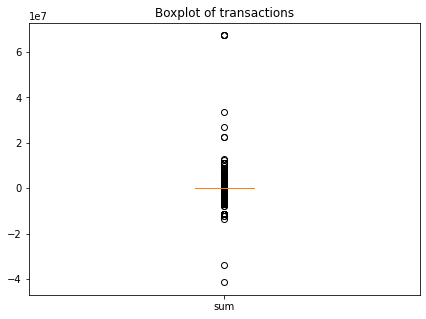

In [12]:
# detecting the outliers

fig, ax = plt.subplots(figsize=(7, 5))
# set plot title
ax.set_title('Boxplot of transactions')

labels = ['sum']
ax.boxplot(transactions['sum'], labels=labels)
plt.show()

> The graph above clearly shows that the transaction table has some outliers.

In [13]:
# removing the outliers

# declare the function remove outlier using IQR
def remove_outlier_IQR(df):
    # IQR
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    # removing the outliers
    df_without_outliers=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    # return data without outliers
    return df_without_outliers

# sum of data tables without outliers
data_with_no_outliers=remove_outlier_IQR(transactions['sum'])

# difference between data with and without outliers
print(len(transactions['sum']) - len(data_with_no_outliers))

28738


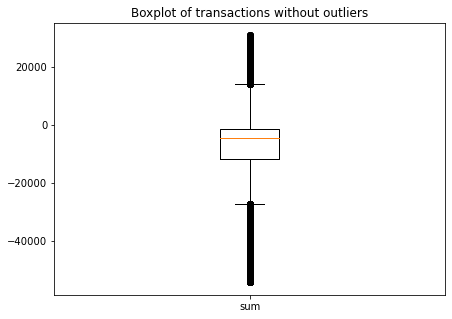

In [14]:
# detecting the outliers

fig, ax = plt.subplots(figsize=(7, 5))
# set plot title
ax.set_title('Boxplot of transactions without outliers')

labels = ['sum']
ax.boxplot(data_with_no_outliers, labels=labels)
plt.show()

> So, I used data_with_no_outliers table to got rid of outliers for more accurate data exploration.

In [15]:
data_with_no_outliers.describe()

count    101301.000000
mean      -7937.569789
std       13454.648800
min      -54422.360000
25%      -11905.600000
50%       -4491.830000
75%       -1572.140000
max       30858.880000
Name: sum, dtype: float64

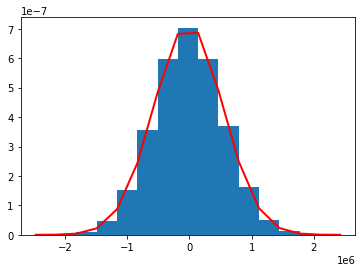

In [16]:
sigma = np.std(transactions['sum'])
mu = np.mean(transactions['sum'])
n = len(transactions['sum'])



s = np.random.normal(loc = mu, scale = sigma, size = n)
count, bins, ignored = plt.hist(s, 15, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

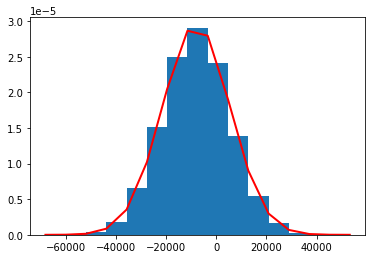

In [17]:
data_with_no_outliers

sigma_no_outl = np.std(data_with_no_outliers)
mu_no_outl = np.mean(data_with_no_outliers)
n_no_outl = len(data_with_no_outliers)


s = np.random.normal(loc = mu_no_outl, scale = sigma_no_outl, size = n_no_outl)
count, bins, ignored = plt.hist(s, 15, density=True)
plt.plot(bins, 1/(sigma_no_outl * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu_no_outl)**2 / (2 * sigma_no_outl**2) ),
         linewidth=2, color='r')
plt.show()

In [18]:
# color class to bold main entries
class color:
    # bold font, intense color
   BOLD = '\033[1m'
   END = '\033[0m' 

# negative transactions for cases where money was withdrawn from the account
negative_sum = transactions[transactions['sum'] < 0]
# positive transactions for cases when replenishing an account
positive_sum = transactions[transactions['sum'] > 0]

mean_pos_sum = np.mean(positive_sum['sum']) # mean for sum of positive transaction
median_pos_sum = np.median(positive_sum['sum']) # median for sum of positive transaction
std_pos_sum = np.std(positive_sum['sum']) # standard deviation for sum of positive transaction
var_pos_sum = np.var(positive_sum['sum']) # variance for sum of positive transaction
min_pos_sum = min(positive_sum['sum']) # minimum sum of positive transaction
max_pos_sum = max(positive_sum['sum']) # maximum sum of positive transactions
mode_pos_sum = st.mode(positive_sum['sum']) # mode for sum of positive transaction


mean_neg_sum = np.mean(negative_sum['sum']) # mean for sum of positive transaction
median_neg_sum = np.median(negative_sum['sum']) # median for sum of positive transaction
std_neg_sum = np.std(negative_sum['sum']) # standard deviation for sum of positive transaction
var_neg_sum = np.var(negative_sum['sum']) # variance for sum of positive transaction
min_neg_sum = min(negative_sum['sum']) # minimum sum of positive transaction
max_neg_sum = max(negative_sum['sum']) # maximum sum of positive transactions
mode_neg_sum = st.mode(negative_sum['sum']) # mode for sum of positive transaction

mean_sum = np.mean(transactions['sum']) # mean for sum of transaction
median_sum = np.median(transactions['sum']) # median for sum of transaction
std_sum = np.std(transactions['sum']) # standard deviation for sum of transaction
var_sum = np.var(transactions['sum']) # variance for sum of transaction
min_sum = min(transactions['sum']) # minimum sum of transaction
max_sum = max(transactions['sum']) # maximum sum of transaction
mode_sum = st.mode(transactions['sum']) # mode for sum of transaction

# get all this information
print('Minimum sum of transaction is {}, maximum is {}'.format(min_sum, max_sum))
print('Mean for sum of transaction is', mean_sum)
print('Median for sum of transaction is', median_sum)
print('Mode for sum of transaction is', mode_sum)
print('Standard deviation for sum of transaction is', std_sum)
print('Variance for sum of transaction is', var_sum,'\n')

print('Minimum sum of',color.BOLD+'positive'+color.END,'transaction is {}, maximum is {}'.format(min_pos_sum, max_pos_sum))
print('Mean for sum of',color.BOLD+'positive'+color.END,'transaction is', mean_pos_sum)
print('Median for sum of',color.BOLD+'positive'+color.END,'transaction is', median_pos_sum)
print('Mode for sum of',color.BOLD+'positive'+color.END,'transaction is', mode_pos_sum)
print('Standard deviation for sum of',color.BOLD+'positive'+color.END,'transaction is', std_pos_sum)
print('Variance for sum of',color.BOLD+'positive'+color.END,'transaction is', var_pos_sum,'\n')

print('Minimum sum of',color.BOLD+'negative'+color.END,'transaction is {}, maximum is {}'.format(min_neg_sum, max_neg_sum))
print('Mean for sum of',color.BOLD+'negative'+color.END,'transaction is', mean_neg_sum)
print('Median for sum of',color.BOLD+'negative'+color.END,'transaction is', median_neg_sum)
print('Mode for sum of',color.BOLD+'negative'+color.END,'transaction is', mode_neg_sum)
print('Standard deviation for sum of',color.BOLD+'negative'+color.END,'transaction is', std_neg_sum)
print('Variance for sum of',color.BOLD+'negative'+color.END,'transaction is', var_neg_sum)

Minimum sum of transaction is -41500301.14, maximum is 67377473.16
Mean for sum of transaction is -18129.09389314057
Median for sum of transaction is -5502.49
Mode for sum of transaction is -2245.92
Standard deviation for sum of transaction is 558442.3752113805
Variance for sum of transaction is 311857886431.7283 

Minimum sum of positive transaction is 0.22, maximum is 67377473.16
Mean for sum of positive transaction is 172174.27666199714
Median for sum of positive transaction is 22459.16
Mode for sum of positive transaction is 22459.16
Standard deviation for sum of positive transaction is 1081321.2725317418
Variance for sum of positive transaction is 1169255694429.6653 

Minimum sum of negative transaction is -41500301.14, maximum is -0.22
Mean for sum of negative transaction is -61887.27754898528
Median for sum of negative transaction is -8983.66
Mode for sum of negative transaction is -2245.92
Standard deviation for sum of negative transaction is 323212.7891787567
Variance for sum 

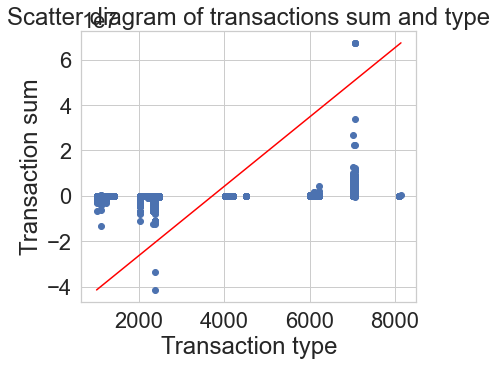

In [55]:
X = transactions['type'] 
y = transactions['sum'] 
 
plt.figure(figsize=(6,5)) 
plt.scatter(X, y)  
plt.plot([min(X), max(X)], [min(y), max(y)], color='red')  # regression line 
plt.xlabel('Transaction type') 
plt.ylabel('Transaction sum') 
plt.title('Scatter diagram of transactions sum and type') 
plt.show()

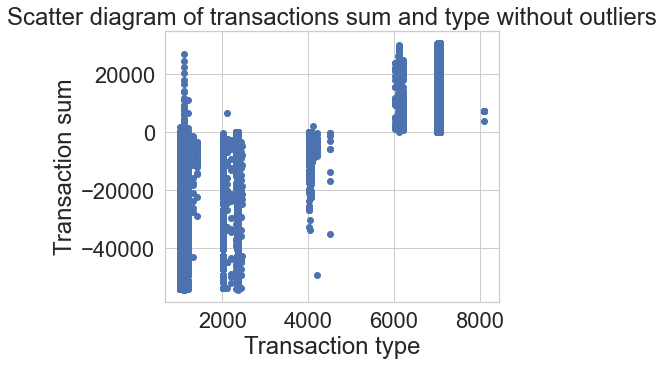

In [56]:
transactions['sum_no_outl'] = pd.Series(data_with_no_outliers, index=transactions.index) 
 
X_ = transactions['type'] 
y_ = transactions['sum_no_outl'] 
 
plt.figure(figsize=(6,5)) 
plt.scatter(X_, y_)  
plt.xlabel('Transaction type') 
plt.ylabel('Transaction sum') 
plt.title('Scatter diagram of transactions sum and type without outliers') 
plt.show()

In [57]:
def calc_time_of_day(time): 
    hour = int(time.split(':')[0]) 
    if (hour>=23) and (hour<6): 
        return 'night' 
    if (hour>=6) and (hour<12): 
        return 'morning' 
    if (hour>=12) and (hour<17): 
        return 'afternoon' 
    return 'evening' 
 
#features from datetime 
transactions['ordered_day'] = transactions.apply(lambda row: row['datetime'].split(' ')[0],axis=1) 
transactions['time'] = transactions.apply(lambda row: row['datetime'].split(' ')[1],axis=1) 
 
transactions['hour'] = transactions.apply(lambda row: int(row['datetime'].split(' ')[1].split(':')[0]),axis=1) 
 
transactions['time_of_day'] = transactions.apply(lambda row: calc_time_of_day(row['time']),axis=1) 
 
transactions.tail()

client_id      datetime  code  type       sum  day  hour part_day  \
130034   15836839  147 11:50:53  5411  1010 -26344.59  147    11  morning   
130035   28369355  305 11:59:34  4829  2330 -24705.07  305    11  morning   
130036   40949707  398 21:13:58  5411  1110 -40353.72  398    21  evening   
130037    7174462  409 13:58:14  5411  1010 -25536.06  409    13  daytime   
130038   92197764  319 00:00:00  5533  1110 -12127.95  319     0    night   

       sum_type  sum_cat ordered_day      time time_of_day day_type  week_num  \
130034  outcome        1         147  11:50:53     morning  weekday        21   
130035  outcome        1         305  11:59:34     morning   friday        43   
130036  outcome        1         398  21:13:58     evening  weekend        56   
130037  outcome        1         409  13:58:14   afternoon  weekday        58   
130038  outcome        1         319  00:00:00     evening   friday        45   

        day_of_week  month  day_of_month  sum_no_outl  
130034            0      4             4    -26344.59  
130035            4     10            10    -24705.07  
130036            6      1            13    -40353.72  
130037            3      1            13    -25536.06  
130038            4     10            10    -12127.95

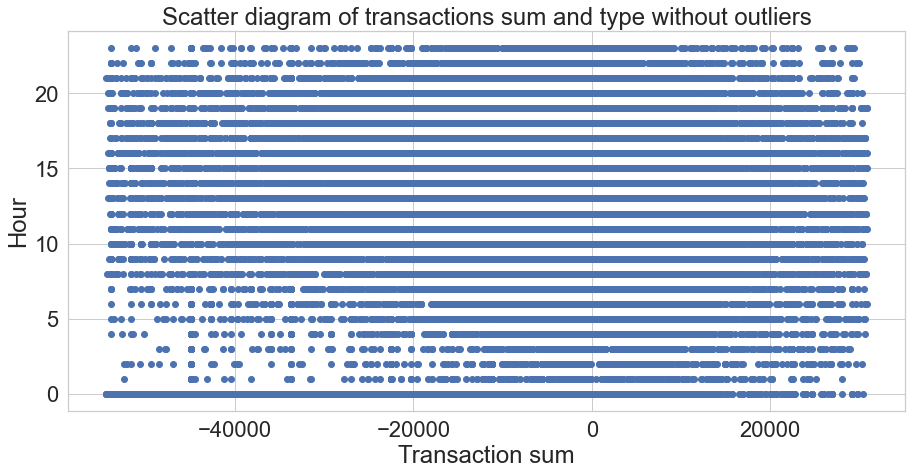

In [58]:
X_ = transactions['sum_no_outl'] 
y_ = transactions['hour'] 
 
plt.figure(figsize=(15,7)) 
plt.scatter(X_, y_)  
plt.xlabel('Transaction sum') 
plt.ylabel('Hour') 
plt.title('Scatter diagram of transactions sum and type without outliers') 
plt.show()

In [59]:
transactions

client_id      datetime  code  type         sum  day  hour part_day  \
0        96372458  421 06:33:15  6011  2010  -561478.94  421     6  morning   
1        24567813  377 17:20:40  6011  7010    67377.47  377    17  daytime   
2        21717441   55 13:38:47  6011  2010   -44918.32   55    13  daytime   
3        14331004  263 12:57:08  6011  2010 -3368873.66  263    12  daytime   
4        85302434  151 10:34:12  4814  1030    -3368.87  151    10  morning   
...           ...           ...   ...   ...         ...  ...   ...      ...   
130034   15836839  147 11:50:53  5411  1010   -26344.59  147    11  morning   
130035   28369355  305 11:59:34  4829  2330   -24705.07  305    11  morning   
130036   40949707  398 21:13:58  5411  1110   -40353.72  398    21  evening   
130037    7174462  409 13:58:14  5411  1010   -25536.06  409    13  daytime   
130038   92197764  319 00:00:00  5533  1110   -12127.95  319     0    night   

       sum_type  sum_cat ordered_day      time time_of_day day_type  week_num  \
0       outcome        0         421  06:33:15     morning  weekday        60   
1        income        5         377  17:20:40     evening  weekend        53   
2       outcome        0          55  13:38:47   afternoon  weekend         7   
3       outcome        0         263  12:57:08   afternoon   friday        37   
4       outcome        3         151  10:34:12     morning   friday        21   
...         ...      ...         ...       ...         ...      ...       ...   
130034  outcome        1         147  11:50:53     morning  weekday        21   
130035  outcome        1         305  11:59:34     morning   friday        43   
130036  outcome        1         398  21:13:58     evening  weekend        56   
130037  outcome        1         409  13:58:14   afternoon  weekday        58   
130038  outcome        1         319  00:00:00     evening   friday        45   

        day_of_week  month  day_of_month  sum_no_outl  
0                 1      2            14          NaN  
1                 6      0            12          NaN  
2                 6      1             1    -44918.32  
3                 4      8             8          NaN  
4                 4      5             5     -3368.87  
...             ...    ...           ...          ...  
130034            0      4             4    -26344.59  
130035            4     10            10    -24705.07  
130036            6      1            13    -40353.72  
130037            3      1            13    -25536.06  
130038            4     10            10    -12127.95  

[130039 rows x 19 columns]

## Explanatory data analysis

Exploratory data analysis is used to analyze and investigate data sets and summarize their main characteristics, employing data visualization methods. It helps determine how best to manipulate data sources to get the answers we need, making it easier for us to discover patterns, test a hypothesis, or check assumptions.

<AxesSubplot:xlabel='code_description'>

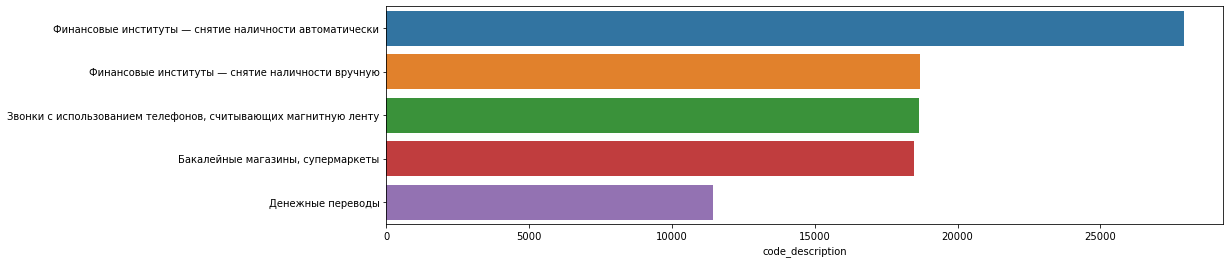

In [19]:
# services most often used by bank customers

fig, axs = plt.subplots(ncols=1) # returns figure using the variable ax for single a Axes
fig.set_figwidth(15) # set the width of the figure

# merge transaction column with codes column by code
data0 = transactions.merge(codes, on='code')
# merge transactions(data0 column) with types column by type
data = data0.merge(types, on='type')

# top 5 of transaction codes
sns.barplot(x=data['code_description'].value_counts()[:5],y=data['code_description'].value_counts()[:5].index)

> In the first place by a wide margin is "Финансовые институты – снятие наличности автоматически", that is, the cashing out of funds in automatic devices, such as ATMs. <br>
In second place also "Финансовые институты" but "снятие наличности вручную", that is, used to determine transactions in person, when the cardholder uses the card at the checkout to receive cash.<br>
Payment for telecommunications services took 3rd place in this top.<br>
"Магазины, супермаркеты" ranked 4th.<br>
"Денежные переводы" ranked 5th in the most frequently used services.<br>
<br>
**We can see that the tops are leading the usual procedures that everyone has in their daily lives.**

<AxesSubplot:xlabel='type_description'>

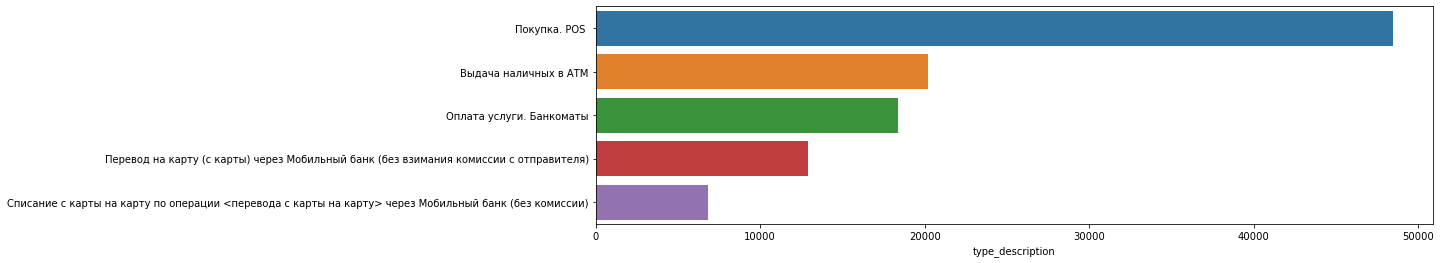

In [20]:
# top 5 of transaction types

fig, axs = plt.subplots(ncols=1) # returns figure using the variable ax for single a Axes
fig.set_figwidth(15) # set the width of the figure

# top 5 of transaction types
sns.barplot(x=data['type_description'].value_counts()[:5],y=data['type_description'].value_counts()[:5].index)

> In first place purchases through the POS terminal.<br> 
Than "Выдача наличных в АТМ, Оплата услуг, Банкоматы, Перевод на карту через мобильный банк, Перевод с карты на карту."
<br> 
**In general, all of these procedures happen every day in our routine and therefore top the ranking of transaction types.**

Text(0.5, 1.0, 'Outcome per gender')

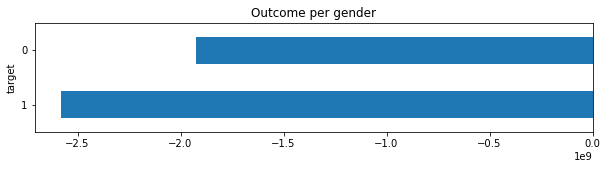

In [21]:
# merge negative sum column with train column by client id
flow_per_gender = pd.merge(negative_sum, train, on='client_id')

# find the negative transaction amount for each gender
flow_per_gender = flow_per_gender.groupby(["target"])["sum"].sum().sort_values()

flow_per_gender.plot(kind='barh', figsize=(10,2)) # plot a graph
plt.title("Outcome per gender") # set plot title

> We can observe that women have more outcome than men.

Text(0.5, 1.0, 'Revenue per gender')

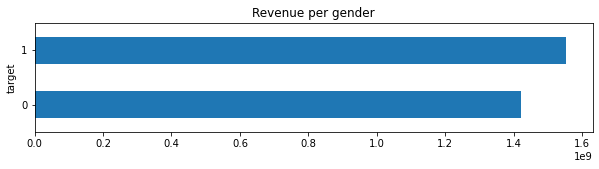

In [22]:
# merge positive sum column with train column by client id
revenue_per_gender = pd.merge(positive_sum, train, on='client_id')

# find the positive transaction amount for each gender
revenue_per_gender = revenue_per_gender.groupby(["target"])["sum"].sum().sort_values()

revenue_per_gender.plot(kind='barh', figsize=(10,2)) # plot a graph
plt.title("Revenue per gender") # set plot title

> We can observe that women also have more revenue than men.

In [23]:
# which part of the day had more transactions

labels = ['Morning', 'Daytime', 'Evening', 'Night'] 
values = [34281, 48928, 24278, 22552] 
 
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)]) 
fig.show()

> In the feature engineering part,
we created a new column with parts of the day and 
counted which part of the day had more transactions.<br>
**As a result, we see that the most transactions were made during the day, and the least at night.**

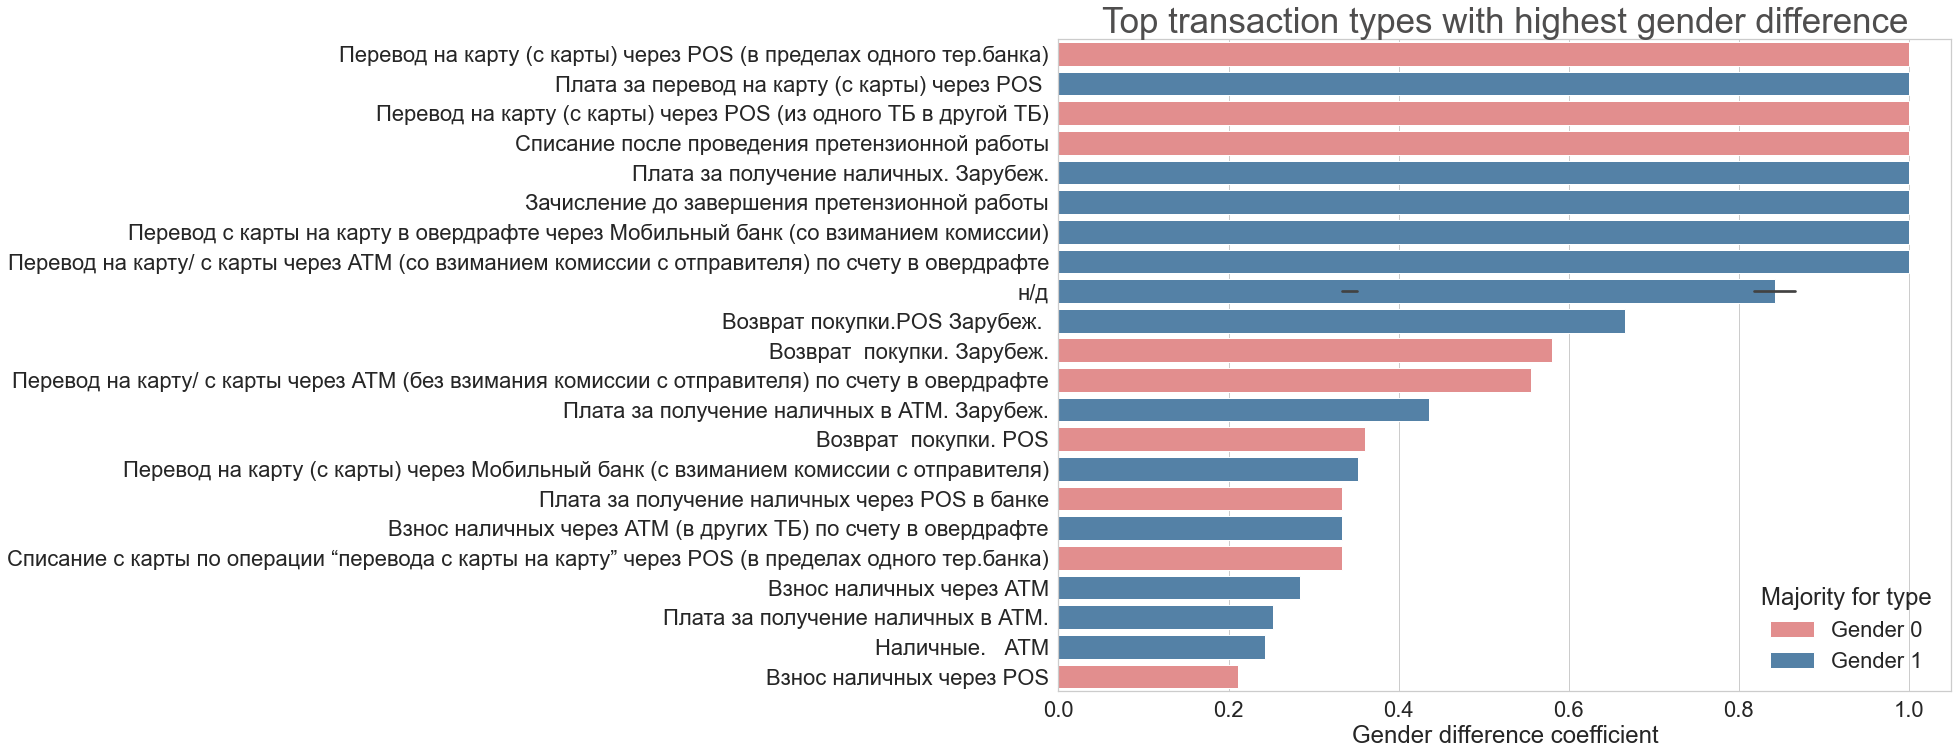

In [24]:
# counting the number of transactions made per gender by transaction type

#searching for male and female categories
train_gender = types.copy(deep=True)
# train_gender['0']=0
# train_gender['1']=1
train_gender['majority']=0

transactions.head()

# merge transaction column with traun column by client id
data_train = pd.merge(transactions, train, on='client_id', how="right")

# declare the function that return count of male by type
def calc_count_0(row):
    return len((data_train[(data_train['type']==row['type']) &(data_train['target']==0)]))

# declare the function that return count of female by type
def calc_count_1(row):
    return len((data_train[(data_train['type']==row['type']) &(data_train['target']==1)]))

# create column for count male and female by transation type
train_gender['0'] = train_gender.apply(lambda row: calc_count_0(row),axis=1)
train_gender['1'] = train_gender.apply(lambda row: calc_count_1(row),axis=1)
    
# find coefficient of prevalence for each type of transation 
train_gender['k'] = abs(train_gender['0']-train_gender['1'])/(train_gender['0']+train_gender['1'])

# find coefficient of prevalence for each type of transation 
train_gender['majority'] = train_gender['1']>train_gender['0']
    
# find whether there is a prevalence of one gender over the other
train_gender.sort_values(by='k',ascending=False).head(15)

plt.figure(figsize=(16,12)) # plot a graph
sns.set(font_scale=2,style='whitegrid')


# plot a graph top transaction with highest gender diffrence
ax = sns.barplot(x="k", y="type_description", data=train_gender.sort_values(by=['k'], ascending=False).head(25),
            hue='majority', palette={True:'steelblue', False:'lightcoral'}, dodge=False)
plt.title('Top transaction types with highest gender difference', size = 35, color='#4f4e4e') 
plt.xlabel('Gender difference coefficient')
plt.ylabel('')

# declare labels
labels = ['Gender 0', 'Gender 1']
h, l = ax.get_legend_handles_labels()

# put labels on our graph
ax.legend(h, labels, title="Majority for type", framealpha=0.0, loc="lower right")

> From this graph we can identify the types of transaction in which one or the other gender prevails.

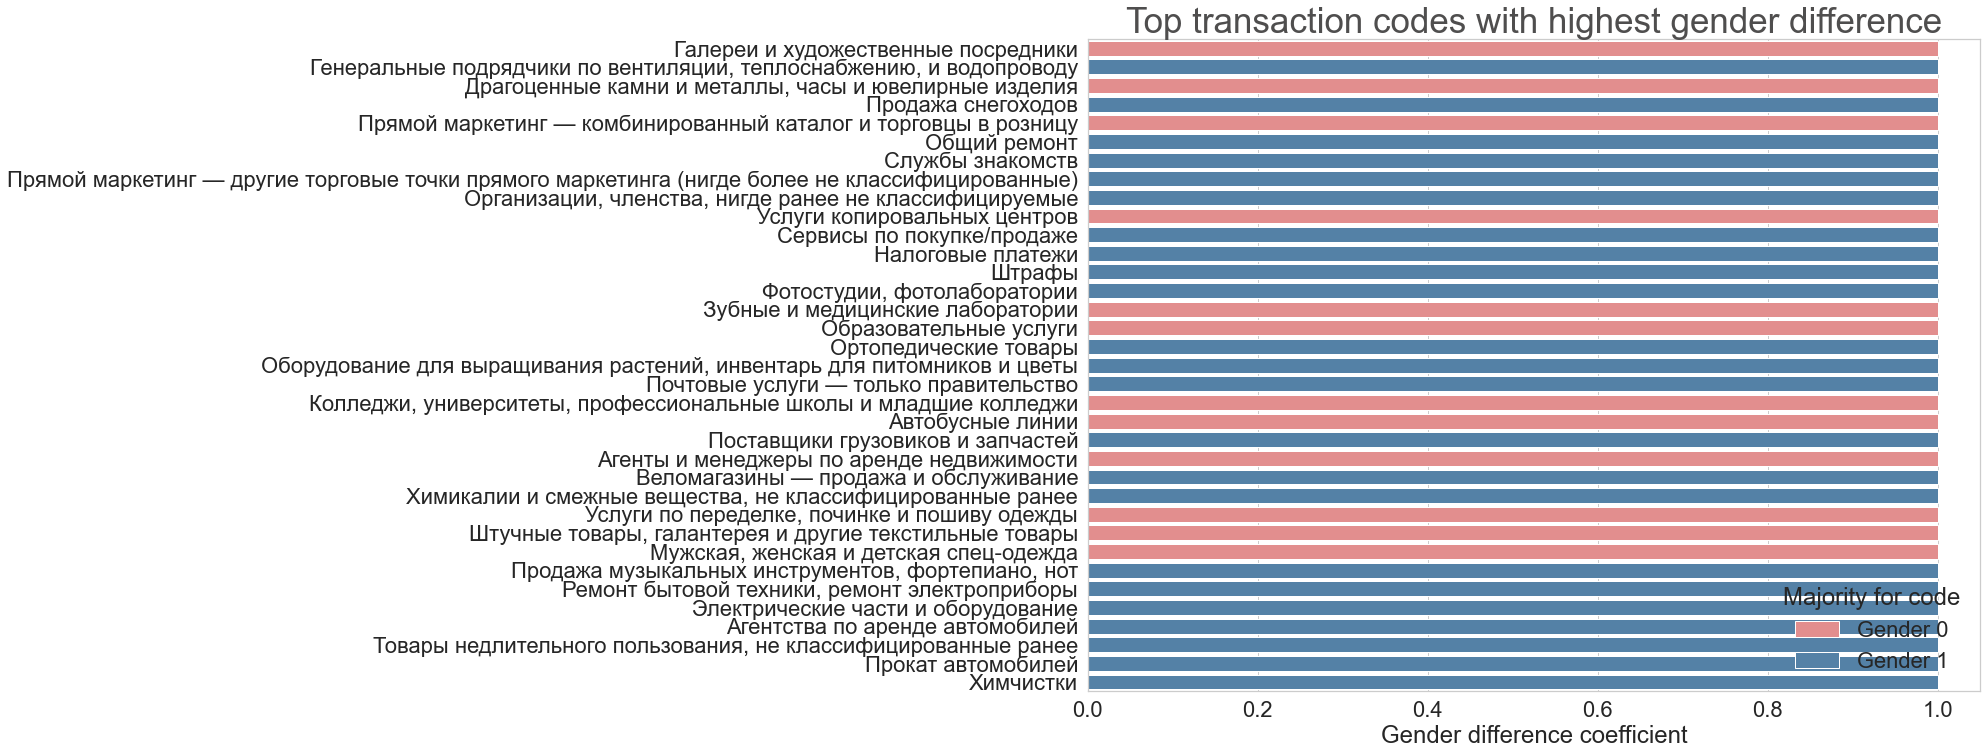

In [25]:
# counting the number of transactions made per gender by code type

#searching for male and female categories
train_gender2 = codes.copy(deep=True)
# train_gender['0']=0
# train_gender['1']=1
train_gender2['majority']=0


transactions.head()

# merge transaction column with train column by client id
data_train = pd.merge(transactions, train, on='client_id', how="right")

# declare the function that return count of male by code
def calc_count_0(row):
    return len((data_train[(data_train['code']==row['code']) &(data_train['target']==0)]))

# declare the function that return count of female by code
def calc_count_1(row):
    return len((data_train[(data_train['code']==row['code']) &(data_train['target']==1)]))

# create column for count male and female by transation code
train_gender2['0'] = train_gender2.apply(lambda row: calc_count_0(row),axis=1)
train_gender2['1'] = train_gender2.apply(lambda row: calc_count_1(row),axis=1)

# find coefficient of prevalence for each code of transation 
train_gender2['k'] = abs(train_gender2['0']-train_gender2['1'])/(train_gender2['0']+train_gender2['1'])

# find coefficient of prevalence for each code of transation 
train_gender2['majority'] = train_gender2['1']>train_gender2['0']
    

plt.figure(figsize=(16,12))
sns.set(font_scale=2,style='whitegrid')

# plot a graph top transaction with highest gender diffrence
ax = sns.barplot(x="k", y="code_description", data=train_gender2.sort_values(by=['k'], ascending=False).head(35),
            hue='majority', palette={True:'steelblue', False:'lightcoral'}, dodge=False)
plt.title('Top transaction codes with highest gender difference', size = 35, color='#4f4e4e') 
plt.xlabel('Gender difference coefficient')
plt.ylabel('')

# declare labels
labels = ['Gender 0', 'Gender 1']
h, l = ax.get_legend_handles_labels()

# put labels on our graph
ax.legend(h, labels, title="Majority for code", framealpha=0.0, loc="lower right")

> From this graph we can identify the code of transaction in which one or the other gender prevails.<br>
**According to the results, we see that the results coincide with the expected outcome. For example, in the art gallery and the purchase of stones, most transactions were made by women, and in the goods for repair and plumbing, most transactions were made by men.**

<AxesSubplot:>

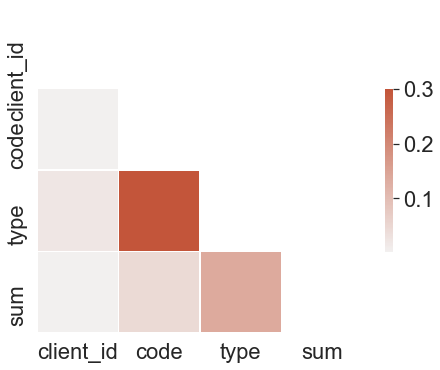

In [26]:
# Compute the correlation matrix
corr = transactions.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

> We checked the correlations between the columns in the transaction table.<br>
**There no correlation between columns.**

## Feature engineering

Feature engineering is the process of selecting, manipulating, and transforming raw data into features which can be used in supervised learning that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data.

In [27]:
# created a new column for parts of the day using the time given to us in the datetime

# function for split using datetime
def conditions_hour(x):
    if (x >= 6) and (x < 12):
        return 'morning'
    elif (x >= 12) and (x < 18):
        return 'daytime'
    elif (x >= 18) and (x <= 23):
        return 'evening'
    else:
        return 'night'
conds_h = np.vectorize(conditions_hour)

#features from datetime
for df in [transactions]:
    df['day'] = [i[:-9] for i in transactions['datetime']]
    df['hour'] = df['datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    part_day = conds_h(df['hour'])
    df['part_day'] = part_day

transactions.head()

client_id      datetime  code  type         sum  day  hour part_day
0   96372458  421 06:33:15  6011  2010  -561478.94  421     6  morning
1   24567813  377 17:20:40  6011  7010    67377.47  377    17  daytime
2   21717441   55 13:38:47  6011  2010   -44918.32   55    13  daytime
3   14331004  263 12:57:08  6011  2010 -3368873.66  263    12  daytime
4   85302434  151 10:34:12  4814  1030    -3368.87  151    10  morning

In [28]:
# data with gender added and without null values

# merge transactions with train by client id
data = transactions.merge(train, how='left', on='client_id')
data = data.dropna() # remove nulls
data

client_id      datetime  code  type        sum  day  hour part_day  \
0        96372458  421 06:33:15  6011  2010 -561478.94  421     6  morning   
2        21717441   55 13:38:47  6011  2010  -44918.32   55    13  daytime   
4        85302434  151 10:34:12  4814  1030   -3368.87  151    10  morning   
5        31421357  398 00:00:00  5411  1110   -1572.14  398     0    night   
6        84826852  423 15:27:55  6010  7070    5654.99  423    15  daytime   
...           ...           ...   ...   ...        ...  ...   ...      ...   
130033   57224158  380 13:52:15  6010  7030    7186.93  380    13  daytime   
130035   28369355  305 11:59:34  4829  2330  -24705.07  305    11  morning   
130036   40949707  398 21:13:58  5411  1110  -40353.72  398    21  evening   
130037    7174462  409 13:58:14  5411  1010  -25536.06  409    13  daytime   
130038   92197764  319 00:00:00  5533  1110  -12127.95  319     0    night   

        target  
0          0.0  
2          0.0  
4          0.0  
5          0.0  
6          1.0  
...        ...  
130033     1.0  
130035     0.0  
130036     1.0  
130037     1.0  
130038     1.0  

[91826 rows x 9 columns]

In [29]:
# transactions made only by womens/mens

# get the transactions that made only womens
girls=data[data['target']==0] 

# get the transactions that made only mens
boys=data[data['target']==1]

girls.head()

client_id      datetime  code  type        sum  day  hour part_day  target
0   96372458  421 06:33:15  6011  2010 -561478.94  421     6  morning     0.0
2   21717441   55 13:38:47  6011  2010  -44918.32   55    13  daytime     0.0
4   85302434  151 10:34:12  4814  1030   -3368.87  151    10  morning     0.0
5   31421357  398 00:00:00  5411  1110   -1572.14  398     0    night     0.0
8   91101111  346 11:06:20  4814  1030   -4491.83  346    11  morning     0.0

In [30]:
# find the type of each code and its number made by each gender

girls = girls['code'].value_counts() # count of womens for each code
girls = pd.DataFrame({'code':girls.index, 'count_w':girls.values})

boys = boys['code'].value_counts() # count of mens for each code
boys = pd.DataFrame({'code':boys.index, 'count_m':boys.values})
boys

code  count_m
0    6011     9622
1    6010     7357
2    5411     6202
3    4814     5615
4    4829     3731
..    ...      ...
155   742        1
156  5931        1
157  7210        1
158  5733        1
159  5949        1

[160 rows x 2 columns]

In [31]:
# total count
count = girls.merge(boys, how='left', on='code').fillna(0)
count = count.set_index('code')
count

count_w  count_m
code                  
6011     9916   9622.0
4814     7429   5615.0
5411     6801   6202.0
6010     6736   7357.0
4829     4403   3731.0
...       ...      ...
1799        1      1.0
5697        1      0.0
7338        1      0.0
5094        1      0.0
6513        1      0.0

[149 rows x 2 columns]

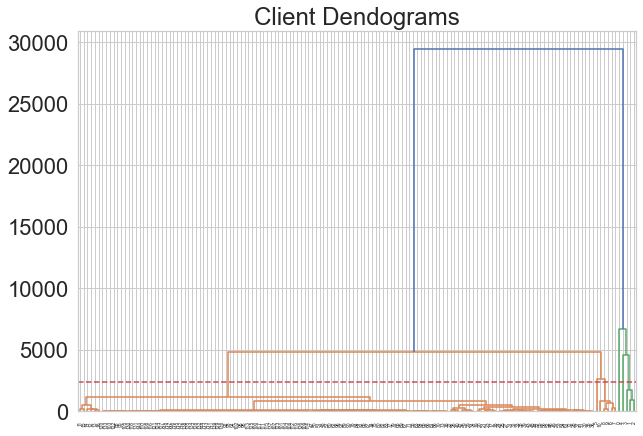

In [32]:
# with dendrogram we consider the appropriate number of clusters

import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Client Dendograms")
dend = shc.dendrogram(shc.linkage(count, method='ward'))
plt.axhline(y=2400, color='r', linestyle='--')

In [33]:
# create an array to add to our dataframe

from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward') # divide into clusters
array = cluster.fit_predict(count)
array

array([5, 0, 0, 0, 4, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [34]:
# dataframe including all the numbers of genders and their clusters

count = count.reset_index()
# add clusters
count_w_c = pd.concat([count, pd.Series(array)], axis=1) 
count_w_c = count_w_c.set_index('code')
count_w_c = count_w_c.rename(columns={0: "cluster"})
count_w_c = count_w_c.reset_index()
count_w_c.head()

code  count_w  count_m  cluster
0  6011     9916   9622.0        5
1  4814     7429   5615.0        0
2  5411     6801   6202.0        0
3  6010     6736   7357.0        0
4  4829     4403   3731.0        4

In [35]:
final = data.merge(count_w_c, how='left', on='code')
final

client_id      datetime  code  type        sum  day  hour part_day  \
0       96372458  421 06:33:15  6011  2010 -561478.94  421     6  morning   
1       21717441   55 13:38:47  6011  2010  -44918.32   55    13  daytime   
2       85302434  151 10:34:12  4814  1030   -3368.87  151    10  morning   
3       31421357  398 00:00:00  5411  1110   -1572.14  398     0    night   
4       84826852  423 15:27:55  6010  7070    5654.99  423    15  daytime   
...          ...           ...   ...   ...        ...  ...   ...      ...   
91821   57224158  380 13:52:15  6010  7030    7186.93  380    13  daytime   
91822   28369355  305 11:59:34  4829  2330  -24705.07  305    11  morning   
91823   40949707  398 21:13:58  5411  1110  -40353.72  398    21  evening   
91824    7174462  409 13:58:14  5411  1010  -25536.06  409    13  daytime   
91825   92197764  319 00:00:00  5533  1110  -12127.95  319     0    night   

       target  count_w  count_m  cluster  
0         0.0   9916.0   9622.0      5.0  
1         0.0   9916.0   9622.0      5.0  
2         0.0   7429.0   5615.0      0.0  
3         0.0   6801.0   6202.0      0.0  
4         1.0   6736.0   7357.0      0.0  
...       ...      ...      ...      ...  
91821     1.0   6736.0   7357.0      0.0  
91822     0.0   4403.0   3731.0      4.0  
91823     1.0   6801.0   6202.0      0.0  
91824     1.0   6801.0   6202.0      0.0  
91825     1.0     46.0    226.0      1.0  

[91826 rows x 12 columns]

> We divided the total into clusters based on the number of transactions made by each client considering their gender. There are only 6 clusters and they are created with the cluster module of the sklearn library.

In [36]:
# trasnsactions features

def calc_time_of_day(x):
    if (x >= 6) and (x < 12):
        return 'morning'
    elif (x >= 12) and (x < 18):
        return 'daytime'
    elif (x >= 18) and (x <= 23):
        return 'evening'
    else:
        return 'night'


def calc_day_type(day):
    if day == 4:
        return 'friday'
    elif (day == 5 or day == 6):
        return 'weekend'
    return 'weekday'

# day_types = np.vectorize(calc_day_type)
#features from sum
transactions['sum_type'] = transactions.apply(lambda row: 'income' if row['sum']>0 else  'outcome',axis=1)

#bins
transactions['sum_cat']= pd.qcut(transactions['sum'],q=6,labels=False)


#features from datetime
transactions['ordered_day'] = transactions.apply(lambda row: int(row['datetime'].split(' ')[0]),axis=1)
transactions['time'] = transactions.apply(lambda row: row['datetime'].split(' ')[1],axis=1)
transactions['hour'] = transactions.apply(lambda row: int(row['datetime'].split(' ')[1].split(':')[0]),axis=1)
transactions['time_of_day'] = transactions.apply(lambda row: calc_time_of_day(row['hour']),axis=1)
transactions['day_type'] = transactions.apply(lambda row: calc_day_type(row['ordered_day']%7),axis=1)

transactions['week_num'] =  transactions['ordered_day'] // 7
transactions['day_of_week'] =  transactions['ordered_day'] % 7
transactions['month'] = transactions['ordered_day'] // 30 % 12
transactions['day_of_month'] = transactions['ordered_day'] // 30 



In [37]:
# client features from transactions features

#client id
clients_data = train.copy()


#try 1
def calc_data(df,lst,suffix,col_name):
    sum_types = ['income','outcome']
    for i in lst:
        for j in sum_types:
            k = suffix+str(i)+'_'+j+'_sum'
            a =suffix+ str(i)+'_'+j+'_avg'
            b =suffix+ str(i)+'_'+j+'_std'
            c =suffix+ str(i)+'_'+j+'_max'
            d =suffix+ str(i)+'_'+j+'_min'
            g =suffix+ str(i)+'_'+j+'_count'
            h =suffix+ str(i)+'_'+j+'_median'
            data = transactions[(transactions[col_name]==i) & (transactions['sum_type']==j)].groupby('client_id').agg(
                k = ('sum',lambda s: s.sum()),
                a = ('sum',lambda s: s.sum()/len(s)),
                b = ('sum',lambda s: np.std(s)),
                c = ('sum',lambda s: np.max(s)),
                d = ('sum',lambda s: np.min(s)),
                g = ('sum',lambda s: len(s)),
                h = ('sum',lambda s: np.median(s))
            ).rename(columns={'a': a,'b':b, 'c':c,'d':d,'g':g,'h':h,'k':k}).reset_index()
            df = df.join(data.set_index('client_id'),on='client_id')
    return df


#try 2
# male_codes = train_gender2[(train_gender2['k']>0.6) & (train_gender2['0']>train_gender2['1'])]
# male_codes = male_codes['code'].unique()

# female_codes = train_gender2[(train_gender2['k']>0.6) & (train_gender2['0']<train_gender2['1'])]
# female_codes = female_codes['code'].unique()
    
# clients_data = transactions.groupby('client_id').agg(
#     max_income = ('sum',lambda s: s[s>0].sum()),
#     max_outcome = ('sum',lambda s: s[s<0].sum()),
#     avg_income =('sum',lambda s: s[s>0].sum()/(len(s[s>0]))),
#     avg_outcome =('sum',lambda s: s[s<0].sum()/(len(s[s<0]))),
#     count_income = ('sum',lambda s: len(s[s>0])),
#     count_outcome = ('sum',lambda s: len(s[s<0])),
#     incomes_to_outcomes = ('sum',lambda s: s[s>0].sum()/s[s<0].sum()),
#     m_codes_count = ('code',lambda c: c.isin(male_codes).sum()),
#     f_codes_count = ('code',lambda c: c.isin(female_codes).sum())
# ).reset_index()
# clients_data['k'] = abs(client_data['m_codes_count']-client_data['f_codes_count'])/(client_data['m_codes_count']+client_data['f_codes_count'])

#by part of day
day_parts = ['night','morning','daytime','evening']
clients_data =calc_data(clients_data,day_parts,'part_day','time_of_day')
#by day type
day_types = ['friday','weekday','weekend']
clients_data =calc_data(clients_data,day_types,'day_type','day_type')
# by codes
codes_with_big_diff = train_gender2[train_gender2['k']>=0.6]
uq_codes = codes_with_big_diff['code'].unique()
clients_data =calc_data(clients_data,uq_codes,'code','code')
#by types
types_with_big_diff = train_gender[train_gender['k']>=0.6]
uq_types = types_with_big_diff['type'].unique()
clients_data =calc_data(clients_data,uq_types,'type','type')
#by hour
clients_data =calc_data(clients_data,[i for i in range(0,24)],'hour','hour')
#by month
clients_data =calc_data(clients_data,[i for i in range(0,12)],'month','month')
# by day of week 
clients_data =calc_data(clients_data,[i for i in range(0,7)],'day_of_week','day_of_week')
#by week_num
clients_data =calc_data(clients_data,[i for i in range(0,66)],'week_num','week_num')




clients_data = clients_data.fillna(0)

#### RFM

In [38]:
# create column rfm

# since the exact date is not given to us, we simply subtract from the last day (456+1) the last day on which the client made a transaction
rfm = transactions.groupby('client_id').agg({'ordered_day': lambda date: (457 - date.astype(int).max()),
                                             'client_id': lambda num: len(num), # show the number of all purchases made by one customer 
                                             'sum': lambda price: price.sum()}) # sum up all costs for each client 
# create columns according to the corresponding data
rfm.columns=['recency', 'frequency', 'monetary'] 
 
# find the quartile using the qcut functions 
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['1','2','3','4']) 
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['4','3','2','1']) 
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['4','3','2','1'])
# find RFM_Score 
rfm['RFM_Score'] = rfm.r_quartile.astype(str) + rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str) 
# display client according to their importance (like they make a lot of purchases, etc.)
rfm[rfm['RFM_Score']=='111'].sort_values('monetary', ascending=False)

recency  frequency     monetary r_quartile f_quartile m_quartile  \
client_id                                                                     
87252636         6        497  21616590.18          1          1          1   
58383596         3         21  19801475.77          1          1          1   
71628575         8         41  13982398.04          1          1          1   
97986854         5         55  13402603.69          1          1          1   
26211677         6         34   9489663.19          1          1          1   
...            ...        ...          ...        ...        ...        ...   
99315139         8         21     -4219.84          1          1          1   
90350810        10         22     -6850.04          1          1          1   
31360931         5         26     -7170.75          1          1          1   
56621830         5         21     -7678.55          1          1          1   
5985987          3         22    -10407.57          1          1          1   

          RFM_Score  
client_id            
87252636        111  
58383596        111  
71628575        111  
97986854        111  
26211677        111  
...             ...  
99315139        111  
90350810        111  
31360931        111  
56621830        111  
5985987         111  

[259 rows x 7 columns]

> Recency, frequency, monetary value (RFM) is a marketing analysis tool used to identify a firm's best clients, based on their spending habits.

In [39]:
rfm[rfm['RFM_Score']=='444'].sort_values('monetary', ascending=False).head()

recency  frequency   monetary r_quartile f_quartile m_quartile  \
client_id                                                                   
58877868        80          5 -422232.18          4          4          4   
43833731        71          5 -430414.27          4          4          4   
66591843       337          4 -431215.83          4          4          4   
6237240         82          4 -432338.79          4          4          4   
22856441       109          4 -437728.99          4          4          4   

          RFM_Score  
client_id            
58877868        444  
43833731        444  
66591843        444  
6237240         444  
22856441        444

In [40]:
# rfm 3d model
import plotly.express as px 
from plotly.offline import iplot 
 
fig = px.scatter_3d(rfm, x='recency',  
                   y='frequency', z='monetary') 
iplot(fig)

In [41]:
rfm.head()

recency  frequency    monetary r_quartile f_quartile m_quartile  \
client_id                                                                    
22899           16          9    50847.54          2          3          1   
27914          165          4    74115.21          4          4          1   
28753           24         13 -2589800.29          2          2          4   
31385          143         13   -83525.38          4          2          2   
38084           28         26   693495.66          3          1          1   

          RFM_Score  
client_id            
22899           231  
27914           441  
28753           224  
31385           422  
38084           311

## Supervised learning

Supervised learning is a machine learning approach that's defined by its use of labeled datasets. These datasets are designed to train or “supervise” algorithms into classifying data or predicting outcomes accurately. Using labeled inputs and outputs, the model can measure its accuracy.

In [60]:
# splitting data

clients_data =  rfm.join(clients_data.set_index('client_id'), on='client_id')

clients_data_wo_na  = clients_data[clients_data['target'].notna()]

from sklearn.model_selection import train_test_split
client_train, client_test = train_test_split(clients_data_wo_na, test_size=0.6,random_state=37)

client_train_x = client_train.loc[:, client_train.columns!='target']
client_train_y = client_train['target']

client_test_x = client_test.loc[:, client_test.columns!='target']
client_test_y = client_test['target']

#### KNN

Test Accuracy 0.5386111111111112
Test ROC AUC: 0.5229733654653783
Test F1 score: 0.4317482039001027
Test recall: 0.40319488817891375
********************
Train Accuracy 0.7029166666666666
Train ROC AUC: 0.6939012229045295
Train F1 score: 0.6447433981066268
Train recall: 0.5908675799086758


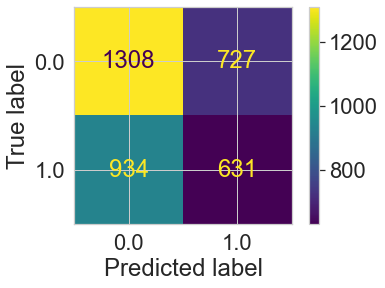

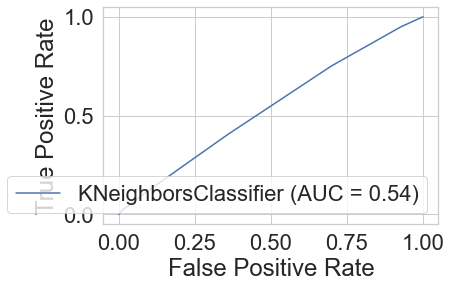

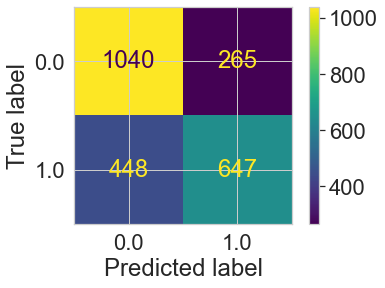

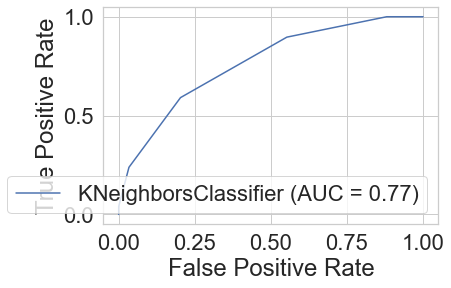

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

# train the model using the training sets
knn.fit(client_train_x, client_train_y)

# predict the response for test dataset
y_pred = knn.predict(client_test_x)


print('Test Accuracy',metrics.accuracy_score(client_test_y,y_pred))
print('Test ROC AUC:', metrics.roc_auc_score(client_test_y, y_pred))
print('Test F1 score:', metrics.f1_score(client_test_y, y_pred))
print('Test recall:', metrics.recall_score(client_test_y, y_pred))

metrics.plot_confusion_matrix(knn,client_test_x,client_test_y)
metrics.plot_roc_curve(knn, client_test_x, client_test_y) 

# create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

# train the model using the training sets
knn.fit(client_train_x, client_train_y)
print('*'*20)

# predict the response for test dataset
y_pred = knn.predict(client_train_x)

print('Train Accuracy',metrics.accuracy_score(client_train_y,y_pred))
print('Train ROC AUC:', metrics.roc_auc_score(client_train_y, y_pred))
print('Train F1 score:', metrics.f1_score(client_train_y, y_pred))
print('Train recall:', metrics.recall_score(client_train_y, y_pred))

metrics.plot_confusion_matrix(knn,client_train_x,client_train_y)
metrics.plot_roc_curve(knn, client_train_x, client_train_y) 

#### Deicision tree

Test Accuracy 0.5344444444444445
Test ROC AUC: 0.5294706847422502
Test F1 score: 0.4785314250155569
Test recall: 0.4913738019169329
Train Accuracy 1.0
Train ROC AUC: 1.0
Train F1 score: 1.0
Train recall: 1.0


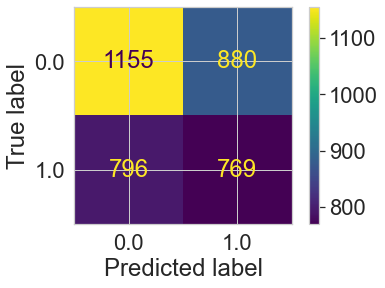

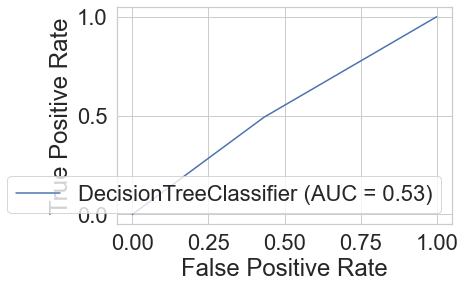

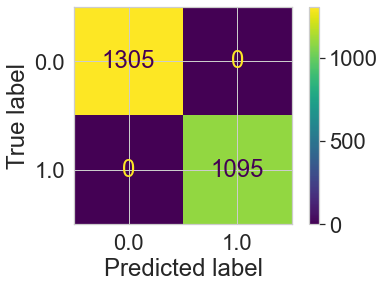

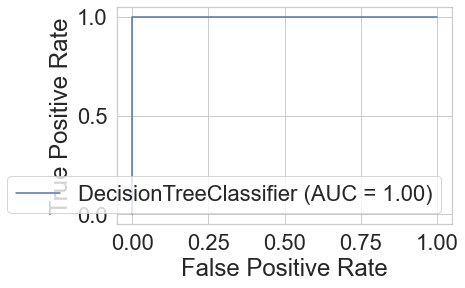

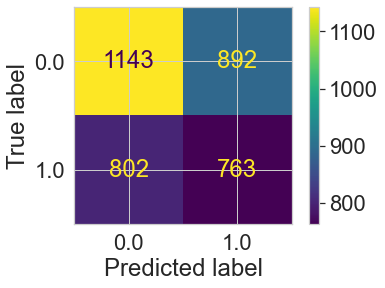

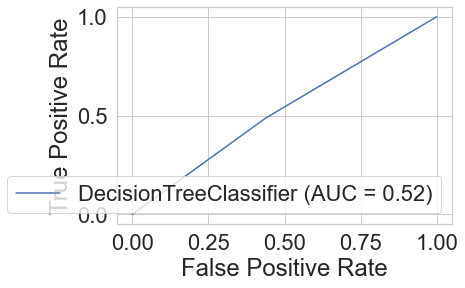

In [45]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()

# train Decision Tree Classifer
clf = clf.fit(client_train_x,client_train_y)

# predict the response for test dataset
y_pred = clf.predict(client_test_x)

metrics.confusion_matrix(client_test_y, y_pred)

print('Test Accuracy',metrics.accuracy_score(client_test_y,y_pred))
print('Test ROC AUC:', metrics.roc_auc_score(client_test_y, y_pred))
print('Test F1 score:', metrics.f1_score(client_test_y, y_pred))
print('Test recall:', metrics.recall_score(client_test_y, y_pred))

metrics.plot_confusion_matrix(clf,client_test_x,client_test_y)
metrics.plot_roc_curve(clf, client_test_x, client_test_y) 

clf = DecisionTreeClassifier()
clf = clf.fit(client_train_x,client_train_y)
y_pred = clf.predict(client_train_x)
print('Train Accuracy',metrics.accuracy_score(client_train_y,y_pred))
print('Train ROC AUC:', metrics.roc_auc_score(client_train_y, y_pred))
print('Train F1 score:', metrics.f1_score(client_train_y, y_pred))
print('Train recall:', metrics.recall_score(client_train_y, y_pred))

metrics.plot_confusion_matrix(clf,client_train_x,client_train_y)
metrics.plot_roc_curve(clf, client_train_x, client_train_y) 

metrics.plot_confusion_matrix(clf,client_test_x,client_test_y)
metrics.plot_roc_curve(clf, client_test_x, client_test_y)

#### Random forest

Test Accuracy 0.635
Test ROC AUC: 0.6129538193435958
Test F1 score: 0.5140532544378699
Test recall: 0.4440894568690096
Train Accuracy 0.9658333333333333
Train ROC AUC: 0.9625570776255707
Train F1 score: 0.9611005692599621
Train recall: 0.9251141552511416


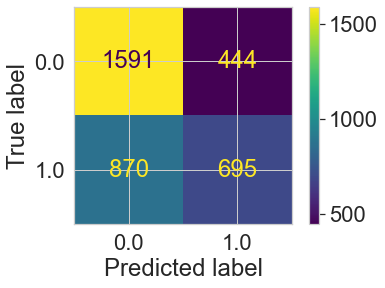

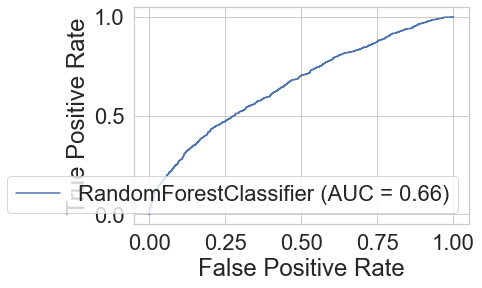

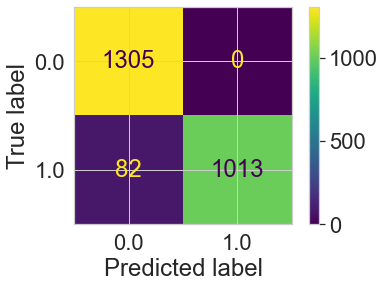

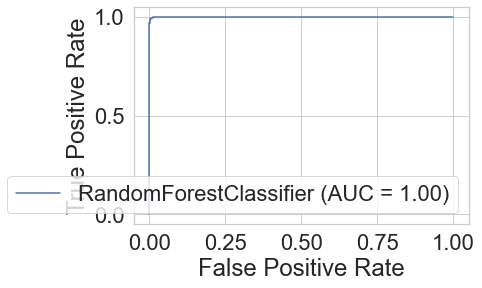

In [46]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=250,
                           bootstrap=False,
                           max_depth=20,
                           min_samples_leaf=3,
                           min_samples_split=3,
                           max_features='auto')


clf.fit(client_train_x,client_train_y)
y_pred=clf.predict(client_test_x)
metrics.confusion_matrix(client_test_y, y_pred)

print('Test Accuracy',metrics.accuracy_score(client_test_y,y_pred))
print('Test ROC AUC:', metrics.roc_auc_score(client_test_y, y_pred))
print('Test F1 score:', metrics.f1_score(client_test_y, y_pred))
print('Test recall:', metrics.recall_score(client_test_y, y_pred))

metrics.plot_confusion_matrix(clf,client_test_x,client_test_y)
metrics.plot_roc_curve(clf, client_test_x, client_test_y) 


clf=RandomForestClassifier(n_estimators=250,
                           bootstrap=False,
                           max_depth=20,
                           min_samples_leaf=3,
                           min_samples_split=3,
                           max_features='auto')


clf.fit(client_train_x,client_train_y)
y_pred=clf.predict(client_train_x)
print('Train Accuracy',metrics.accuracy_score(client_train_y,y_pred))
print('Train ROC AUC:', metrics.roc_auc_score(client_train_y, y_pred))
print('Train F1 score:', metrics.f1_score(client_train_y, y_pred))
print('Train recall:', metrics.recall_score(client_train_y, y_pred))

metrics.plot_confusion_matrix(clf,client_train_x,client_train_y)
metrics.plot_roc_curve(clf, client_train_x, client_train_y) 



In [52]:
from sklearn.model_selection import GridSearchCV

grid_param = {  
    'n_estimators': [50,70,100,250],
    'criterion': ['gini','entropy'],
    'bootstrap': [False,True],
    'max_depth': [20,30,10],
    'min_samples_split': [3,9],
    'max_features':['auto','sqrt']
    }

gs = GridSearchCV(estimator=clf,  
                     param_grid=grid_param,
                     scoring='roc_auc',
                     cv=5,
                     n_jobs=-1)

gs.fit(client_train_x, client_train_y)

print(gs.best_params_)

{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 250}


In [49]:
# try 2

clients_data=train.copy()

male_codes = train_gender2[(train_gender2['k']>0.6) & (train_gender2['0']>train_gender2['1'])]
male_codes = male_codes['code'].unique()

female_codes = train_gender2[(train_gender2['k']>0.6) & (train_gender2['0']<train_gender2['1'])]
female_codes = female_codes['code'].unique()
    
dt = transactions.groupby('client_id').agg(
    max_income = ('sum',lambda s: s[s>0].sum()),
    max_outcome = ('sum',lambda s: s[s<0].sum()),
    avg_income =('sum',lambda s: s[s>0].sum()/(len(s[s>0]))),
    avg_outcome =('sum',lambda s: s[s<0].sum()/(len(s[s<0]))),
    count_income = ('sum',lambda s: len(s[s>0])),
    count_outcome = ('sum',lambda s: len(s[s<0])),
    m_codes_count = ('code',lambda c: c.isin(male_codes).sum()),
    f_codes_count = ('code',lambda c: c.isin(female_codes).sum())
).reset_index()

clients_data = clients_data.join(dt.set_index('client_id'),on='client_id')

# clients_data['k'] = abs(clients_data['m_codes_count']-clients_data['f_codes_count'])/(clients_data['m_codes_count']+clients_data['f_codes_count'])


clients_data.head()

<ipython-input-49-038313808744>:14: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-49-038313808744>:14: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-49-038313808744>:14: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-49-038313808744>:14: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-49-038313808744>:14: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-49-038313808744>:14: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-49-038313808744>:14: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-49-038313808744>:14: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-49-038313808744>:14: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-49-038313808744>:14: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-49-03

client_id  target  max_income  max_outcome     avg_income   avg_outcome  \
0   75063019       0   543511.62   -454479.02  271755.810000 -16832.556296   
1   86227647       1   123525.37   -729583.97   61762.685000 -29183.358800   
2    6506523       0  2883216.82   -247463.08   87370.206667 -12373.154000   
3   50615998       0    22459.16    -65131.56   11229.580000 -13026.312000   
4   95213230       0   449183.16   -234890.50  224591.580000  -7340.328125   

   count_income  count_outcome  m_codes_count  f_codes_count  
0           2.0           27.0              0              0  
1           2.0           25.0              0              0  
2          33.0           20.0              0              0  
3           2.0            5.0              0              0  
4           2.0           32.0              1              0

In [50]:
clients_data = clients_data.fillna(0)

clients_data_wo_na  = clients_data[clients_data['target'].notna()]

client_train, client_test = train_test_split(clients_data_wo_na, test_size=0.2,random_state=37)

client_train_x = client_train.loc[:, client_train.columns!='target']
client_train_y = client_train['target']

client_test_x = client_test.loc[:, client_test.columns!='target']
client_test_y = client_test['target']

Test Accuracy 0.5291666666666667
Test ROC AUC: 0.5121233455364685
Test F1 score: 0.40713536201469047
Test recall: 0.3660377358490566
********************
Train Accuracy 0.69875
Train ROC AUC: 0.6883367621459091
Train F1 score: 0.6370481927710844
Train recall: 0.5957746478873239
********************
Test Accuracy 0.5741666666666667
Test ROC AUC: 0.568389186144748
Test F1 score: 0.5183788878416588
Test recall: 0.5188679245283019
********************
Train Accuracy 1.0
Train ROC AUC: 1.0
Train F1 score: 1.0
Train recall: 1.0
********************
Test Accuracy 0.62
Test ROC AUC: 0.6037172627428893
Test F1 score: 0.5189873417721519
Test recall: 0.4641509433962264
********************
********************
Train Accuracy 0.96625
Train ROC AUC: 0.9628263965817376
Train F1 score: 0.9608127721335269
Train recall: 0.9323943661971831


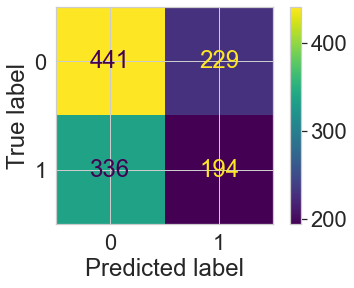

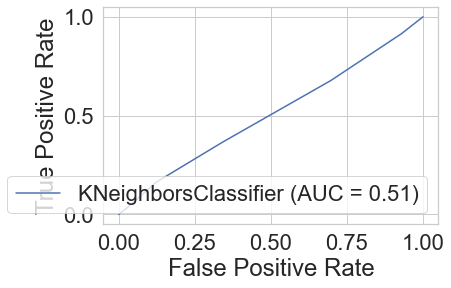

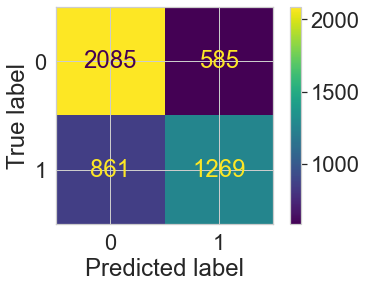

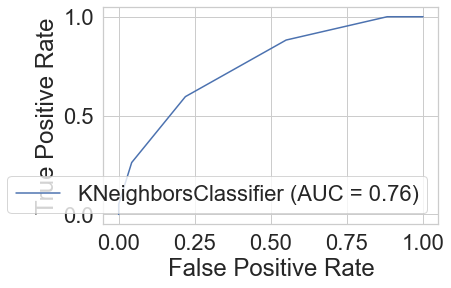

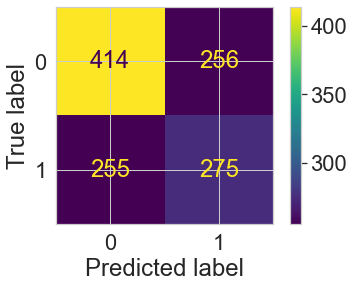

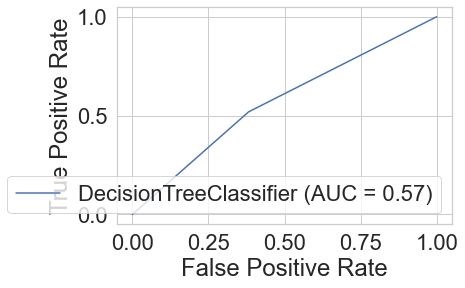

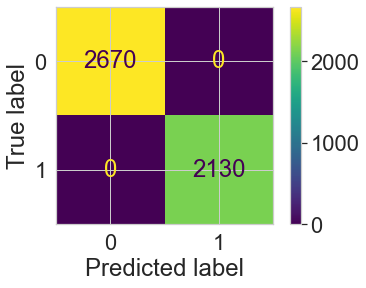

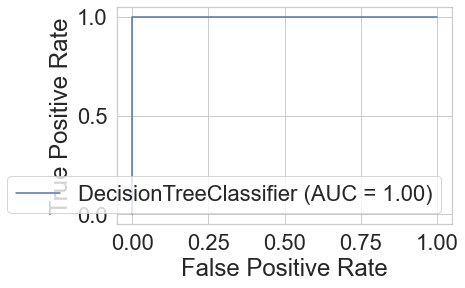

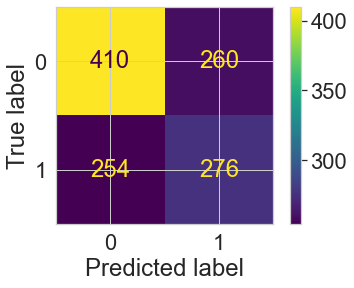

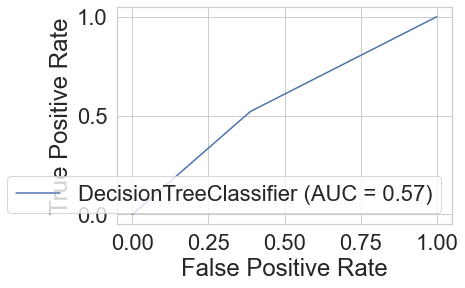

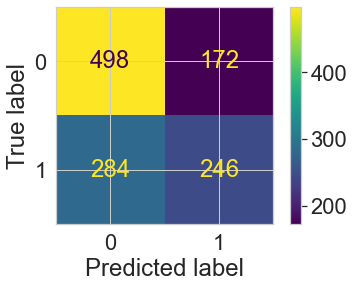

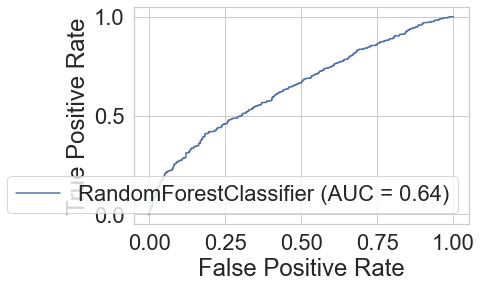

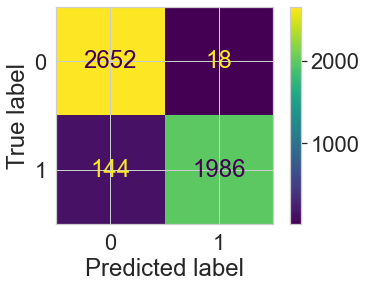

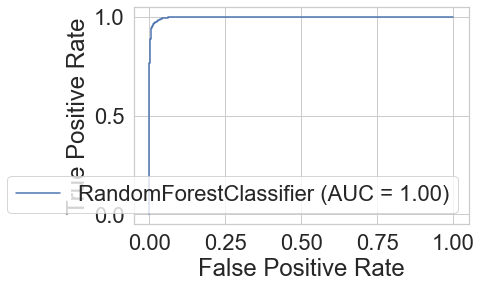

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

# train the model using the training sets
knn.fit(client_train_x, client_train_y)

# predict the response for test dataset
y_pred = knn.predict(client_test_x)


print('Test Accuracy',metrics.accuracy_score(client_test_y,y_pred))
print('Test ROC AUC:', metrics.roc_auc_score(client_test_y, y_pred))
print('Test F1 score:', metrics.f1_score(client_test_y, y_pred))
print('Test recall:', metrics.recall_score(client_test_y, y_pred))

metrics.plot_confusion_matrix(knn,client_test_x,client_test_y)
metrics.plot_roc_curve(knn, client_test_x, client_test_y) 

# create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

# train the model using the training sets
knn.fit(client_train_x, client_train_y)


print('*'*20)
# predict the response for test dataset
y_pred = knn.predict(client_train_x)

print('Train Accuracy',metrics.accuracy_score(client_train_y,y_pred))
print('Train ROC AUC:', metrics.roc_auc_score(client_train_y, y_pred))
print('Train F1 score:', metrics.f1_score(client_train_y, y_pred))
print('Train recall:', metrics.recall_score(client_train_y, y_pred))

metrics.plot_confusion_matrix(knn,client_train_x,client_train_y)
metrics.plot_roc_curve(knn, client_train_x, client_train_y) 

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()

# train Decision Tree Classifer
clf = clf.fit(client_train_x,client_train_y)

#Predict the response for test dataset
y_pred = clf.predict(client_test_x)

metrics.confusion_matrix(client_test_y, y_pred)
print('*'*20)
print('Test Accuracy',metrics.accuracy_score(client_test_y,y_pred))
print('Test ROC AUC:', metrics.roc_auc_score(client_test_y, y_pred))
print('Test F1 score:', metrics.f1_score(client_test_y, y_pred))
print('Test recall:', metrics.recall_score(client_test_y, y_pred))

metrics.plot_confusion_matrix(clf,client_test_x,client_test_y)
metrics.plot_roc_curve(clf, client_test_x, client_test_y) 
print('*'*20)
clf = DecisionTreeClassifier()
clf = clf.fit(client_train_x,client_train_y)
y_pred = clf.predict(client_train_x)
print('Train Accuracy',metrics.accuracy_score(client_train_y,y_pred))
print('Train ROC AUC:', metrics.roc_auc_score(client_train_y, y_pred))
print('Train F1 score:', metrics.f1_score(client_train_y, y_pred))
print('Train recall:', metrics.recall_score(client_train_y, y_pred))
print('*'*20)
metrics.plot_confusion_matrix(clf,client_train_x,client_train_y)
metrics.plot_roc_curve(clf, client_train_x, client_train_y) 

metrics.plot_confusion_matrix(clf,client_test_x,client_test_y)
metrics.plot_roc_curve(clf, client_test_x, client_test_y) 

from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=250,
                           bootstrap=False,
                           max_depth=20,
                           min_samples_leaf=3,
                           min_samples_split=3,
                           max_features='auto')


clf.fit(client_train_x,client_train_y)
y_pred=clf.predict(client_test_x)
metrics.confusion_matrix(client_test_y, y_pred)

print('Test Accuracy',metrics.accuracy_score(client_test_y,y_pred))
print('Test ROC AUC:', metrics.roc_auc_score(client_test_y, y_pred))
print('Test F1 score:', metrics.f1_score(client_test_y, y_pred))
print('Test recall:', metrics.recall_score(client_test_y, y_pred))
print('*'*20)
metrics.plot_confusion_matrix(clf,client_test_x,client_test_y)
metrics.plot_roc_curve(clf, client_test_x, client_test_y) 


clf=RandomForestClassifier(n_estimators=250,
                           bootstrap=False,
                           max_depth=20,
                           min_samples_leaf=3,
                           min_samples_split=3,
                           max_features='auto')


clf.fit(client_train_x,client_train_y)
y_pred=clf.predict(client_train_x)
print('*'*20)
print('Train Accuracy',metrics.accuracy_score(client_train_y,y_pred))
print('Train ROC AUC:', metrics.roc_auc_score(client_train_y, y_pred))
print('Train F1 score:', metrics.f1_score(client_train_y, y_pred))
print('Train recall:', metrics.recall_score(client_train_y, y_pred))

metrics.plot_confusion_matrix(clf,client_train_x,client_train_y)
metrics.plot_roc_curve(clf, client_train_x, client_train_y) 

## Analyze models

## Conclusion